# Importing Libs

In [ ]:
import pandas as pd
import numpy as np
import glob
import os
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')

**Specify the `exportdate` below**

In [ ]:
exportdate = pd.Timestamp('2022-12-14T12')

# Computing Feature 1: Warningsign

## Importing dataset

Place all your "file.csv" files in a folder named files and then use its path as mentioned below

In [ ]:
# use list comprehension to read all files
path = r"files"
all_files = [pd.read_csv(filename, dtype={'BizDomainId': 'string', 'DealId': 'string'}, low_memory=False) for filename in glob.glob(os.path.join(path , "*.csv"))]

# combine dataframes into a single dataframe
df = pd.concat(all_files, axis=0, ignore_index=True)

# rename columns
df = df.rename(columns={'IsDeleted':'IsDeletedDeal','Id':'DealId' , 'Id.1':'ActivityId','IsDeleted.1':'IsDeletedActivity','RegisterTime':'RegisterTimeDeal',
                        'Status':'StatusDeal','RegisterDate':'RegisterDateActivity','IsDone':'IsDoneActivity','DoneDate':'DoneDateActivity'})

# manipulate columns
df['BizDomainId'] = df['BizDomainId'].str.lower()
df['DealId'] = df['DealId'].str.lower()
df['DoneDateActivity'] = np.where(df['IsDoneActivity']==False , np.nan ,df['DoneDateActivity'])
df['DealFinishTime'] = np.where(df['StatusDeal']==1 , df['ChangeToWonTime'] , np.where(df['StatusDeal']==2 , df['ChangeToLossTime'] , None))
df['temp'] = np.nanmax(df[['RegisterDateActivity' , 'DoneDateActivity' , 'DealFinishTime' , 'RegisterTimeDeal']].fillna('00'), axis=1)
df['temp'] = pd.to_datetime(df['temp'], errors='coerce', format='%Y%m%d %H:%M:%S')
df = df[~pd.isna(df['temp'])]
del df['temp']

# convert date/time columns to datetime dtype
df['RegisterDateActivity'] = pd.to_datetime(df['RegisterDateActivity'])
df['DoneDateActivity'] = pd.to_datetime(df['DoneDateActivity'])
df['RegisterTimeDeal'] = pd.to_datetime(df['RegisterTimeDeal'])
df['DealFinishTime'] = pd.to_datetime(df['DealFinishTime'])

# drop columns
df.drop(['ChangeToWonTime' , 'ChangeToLossTime' , 'ActivityId'], axis=1, inplace=True)

# print results
print(f'Number of rows: {df.shape[0]}')
df.head()


Number of rows: 1150296


,BizDomainId,DealId,IsDeletedDeal,RegisterTimeDeal,StatusDeal,IsDeletedActivity,RegisterDateActivity,IsDoneActivity,DoneDateActivity,DealFinishTime
0,6e05f84a-d924-463c-950d-7c3b0fc54563,d4534ab2-f38c-4921-8ce3-10e198fcefcb,0,2022-11-26 11:58:43,0,0.0,2022-11-26 11:59:03,1.0,2022-11-26 12:00:46,NaT
1,b3073526-6802-4673-bbee-1d24852107cb,d368cbcc-5341-49d7-9dd6-1b76337b4cb4,0,2022-11-28 12:39:10,1,0.0,2022-11-28 01:03:24,1.0,2022-11-28 01:03:20,2022-11-28 01:05:11
2,ce38a1c6-190c-4dc9-8fa8-2966e46fb229,a513fe99-0b36-46de-bbc9-23736faa0b9e,0,2022-10-23 09:26:00,2,0.0,2022-10-23 09:28:37,0.0,NaT,2022-10-31 11:55:13
3,91989786-ca50-4b32-a087-48d1af76ea54,1416ec41-ef71-4443-86ef-f5a8f13debe4,0,2022-12-13 01:47:32,0,0.0,2022-12-13 01:47:46,1.0,2022-12-13 01:47:46,NaT
4,a8548620-a47a-459d-8d67-deac4e6d5ae7,3385e579-2e31-44fc-8076-d1ff960fefe6,0,2022-12-12 05:00:18,0,0.0,2022-12-12 05:00:21,1.0,2022-12-12 05:59:55,NaT


## Joining ExpireDate Dataset

In [ ]:
# Load and merge the expiration date data
ExpireDate = pd.read_csv(r"Training Data\ExpireDate.csv", dtype={"Id": str})
ExpireDate = ExpireDate.rename(columns={'Id':'BizDomainId','RegisterTime':'BizRegisterDate','ExpirationDate':'BizExpireDate' , 'LastAccessTime':'BizAccessDate'})
ExpireDate['BizDomainId'] = ExpireDate['BizDomainId'].str.lower()
df = pd.merge(df, ExpireDate, how='left')

# Convert datetime columns
date_columns = ['BizRegisterDate', 'BizExpireDate', 'BizAccessDate']
df[date_columns] = df[date_columns].apply(pd.to_datetime)

# Determine whether the business is expired
df['BizIsExpired?'] = np.where(df['BizExpireDate'] >= exportdate, 0, 1)

# Keep the bizdomains that last longer than 2 months
from dateutil.relativedelta import relativedelta
df = df[df['BizRegisterDate'] <= (exportdate - relativedelta(months=2))]

# Delete data where IsDeletedDeal=1 and StatusDeal=0
mask = df.query('IsDeletedDeal == 1 and StatusDeal == 0').index
shape1 = len(df)
df = df.loc[~df.index.isin(mask)]
shape2 = len(df)
print(f"Number of deleted cases: {shape1-shape2}, number of rows before: {shape1}, number of rows after: {shape2}")


Number of deleted cases: 64376, number of rows before: 1092791, number of rows after: 1028415


In [ ]:
def apply_function(df):
    mask = (df['StatusDeal'] == 0) & (df['IsDeletedDeal'] == 0)
    expired_mask = mask & (df['BizIsExpired?'] == 1)
    df.loc[expired_mask, 'DealFinishTime'] = np.minimum(df.loc[expired_mask, 'BizExpireDate'], df.loc[expired_mask, 'BizAccessDate'])
    df.loc[expired_mask & (df['IsDoneActivity'] == 0) & (df['IsDeletedActivity'] == 0), 'DoneDateActivity'] = df.loc[expired_mask, 'DealFinishTime']
    df.loc[mask & ~(df['BizIsExpired?'] == 1), 'DealFinishTime'] = exportdate
    df.loc[mask & ~(df['BizIsExpired?'] == 1) & (df['IsDoneActivity'] == 0) & (df['IsDeletedActivity'] == 0), 'DoneDateActivity'] = exportdate
    df.drop(columns=['BizAccessDate' , 'BizExpireDate' , 'BizRegisterDate'], inplace=True)
    return df

df = apply_function(df)
df.head()

,BizDomainId,DealId,IsDeletedDeal,RegisterTimeDeal,StatusDeal,IsDeletedActivity,RegisterDateActivity,IsDoneActivity,DoneDateActivity,DealFinishTime,BizIsExpired?
0,6e05f84a-d924-463c-950d-7c3b0fc54563,d4534ab2-f38c-4921-8ce3-10e198fcefcb,0,2022-11-26 11:58:43,0,0.0,2022-11-26 11:59:03,1.0,2022-11-26 12:00:46,2022-12-14 12:00:00,0
1,b3073526-6802-4673-bbee-1d24852107cb,d368cbcc-5341-49d7-9dd6-1b76337b4cb4,0,2022-11-28 12:39:10,1,0.0,2022-11-28 01:03:24,1.0,2022-11-28 01:03:20,2022-11-28 01:05:11,0
2,ce38a1c6-190c-4dc9-8fa8-2966e46fb229,a513fe99-0b36-46de-bbc9-23736faa0b9e,0,2022-10-23 09:26:00,2,0.0,2022-10-23 09:28:37,0.0,NaT,2022-10-31 11:55:13,0
3,91989786-ca50-4b32-a087-48d1af76ea54,1416ec41-ef71-4443-86ef-f5a8f13debe4,0,2022-12-13 01:47:32,0,0.0,2022-12-13 01:47:46,1.0,2022-12-13 01:47:46,2022-12-14 12:00:00,0
4,a8548620-a47a-459d-8d67-deac4e6d5ae7,3385e579-2e31-44fc-8076-d1ff960fefe6,0,2022-12-12 05:00:18,0,0.0,2022-12-12 05:00:21,1.0,2022-12-12 05:59:55,2022-12-14 12:00:00,0


Function for Fixing the order of the times of occurrence

DealStartTime<ActivityStartTime<ActivityFinishTime<DealFinishTime

In [ ]:
df['RegisterTimeDeal']=np.minimum(df['RegisterTimeDeal'] , df['DealFinishTime'])
mask = ~pd.isna(df['RegisterDateActivity'])
df.loc[mask, 'RegisterDateActivity'] = np.maximum(df.loc[mask, 'RegisterTimeDeal'] ,
                                     np.minimum(df.loc[mask,'RegisterDateActivity'] , df.loc[mask,'DealFinishTime']))
df.loc[mask , 'DoneDateActivity'] = np.minimum(df.loc[mask,'DealFinishTime'] ,
                                     np.maximum(df.loc[mask,'RegisterTimeDeal'] , df.loc[mask,'DoneDateActivity']))
df.loc[mask,'DoneDateActivity'] = np.maximum(df.loc[mask,'RegisterDateActivity'] , df.loc[mask , 'DoneDateActivity'])

Activity: IsDone=0, IsDeleted=1

In [ ]:
mask = (df['IsDoneActivity']==0) & (df['IsDeletedActivity']==1)
df = df.loc[~mask ,:]

Completing finish time of activities

In [ ]:
# Calculate average of other activities of deal
df['diff'] = (df['DoneDateActivity'] - df['RegisterDateActivity']).dt.total_seconds()
df['avg_diff_deal'] = df['diff'].groupby(df['DealId']).transform(lambda x: np.nanmean(x))
mask_deal = pd.isna(df['DoneDateActivity']) & (df.groupby('DealId')['DealId'].transform('size') > 1)
df.loc[mask_deal, 'DoneDateActivity'] = df.loc[mask_deal, 'RegisterDateActivity'] + pd.to_timedelta(df.loc[mask_deal, 'avg_diff_deal'], unit='s')
df.drop(columns=['diff', 'avg_diff_deal'], inplace=True)

# Calculate average of other activities of biz
df['diff'] = (df['DoneDateActivity'] - df['RegisterDateActivity']).dt.total_seconds()
df['avg_diff_biz'] = df['diff'].groupby(df['BizDomainId']).transform(lambda x: np.nanmean(x))
mask_biz = pd.isna(df['DoneDateActivity'])
df.loc[mask_biz, 'DoneDateActivity'] = df.loc[mask_biz, 'RegisterDateActivity'] + pd.to_timedelta(df.loc[mask_biz, 'avg_diff_biz'], unit='s')
df.drop(columns=['diff', 'avg_diff_biz'], inplace=True)

# Clip DoneDateActivity to DealFinishTime
df['DoneDateActivity'] = np.minimum(df['DoneDateActivity'], df['DealFinishTime'])

In [ ]:
df.shape

(995709, 11)

## Export Cleaned Dataset

Export data based on the shape of the df, each 1,000,000 rows should be saved a separate csv file

In [ ]:
os.makedirs('files_cleaned', exist_ok=True)
for i, chunk in enumerate(df.groupby(np.arange(len(df)) // 1000000)):
    chunk[1].to_csv(f'files_cleaned/df_file_cleaned{i+1}.csv', index=False)

**Importing the cleaned dataset**

Change the directory of exported data to `files_cleaned` and then use the cell below if you desire to use them. Exporting should be done because the cleaned dataset will be used in future Feature Extractions.

In [ ]:
# path = r"files_cleaned" # use your path
# all_files = glob.glob(os.path.join(path , "*.csv"))

# li = []

# for filename in all_files:
#     df = pd.read_csv(filename, index_col=0, header=0)
#     li.append(df)

# df = pd.concat(li, axis=0, ignore_index=True)
# df.loc[:, ['RegisterTimeDeal' , 'DealFinishTime','RegisterDateActivity','DoneDateActivity']] = df.loc[:,['RegisterTimeDeal' , 'DealFinishTime','RegisterDateActivity','DoneDateActivity']].apply(pd.to_datetime)
# df.head()

Function for calculating the metric of proportion of warning time to total deal time

In [ ]:
def merge_times(intervals):
    intervals.sort(key=lambda x: x[0])

    res = [intervals[0]]
    for idx in range(1, len(intervals)):
        curr = intervals[idx]
        prev = res[-1]

        # Check for overlap
        if prev[1] < curr[0]:  # No overlap
            res.append(curr)
        else:
            # Overlap, update end time
            prev[1] = max(prev[1], curr[1])

    return res

def no_warning_ratio(start_time, end_time, intervals):
    '''
    input:
    start_time = RegisterTime of a deal
    end_time = DealFinishTime
    intervals = related intervals for activities on a specific deal

    ----------------------

    output:
    a dictionary with the following keys:
    - 'no_warning_ratio': ratio of (not showing warning signal)/(duration of the deal)
    - 'deal_duration': duration of the deal in seconds
    '''
    end_time_int = pd.Timedelta(end_time - start_time).total_seconds()

    if pd.isna(intervals.iloc[0, 0]):
        return {'no_warning_ratio': 0, 'deal_duration': end_time_int}
    elif end_time_int == 0:
        return {'no_warning_ratio': 0, 'deal_duration': 0}
    else:
        intervals = intervals.sub(start_time).apply(lambda x: x.dt.total_seconds()).values.tolist()
        merged = merge_times(intervals)
        with_activity = np.sum(end - start for start, end in merged)
        ratio = with_activity / end_time_int
        return {'no_warning_ratio': ratio, 'deal_duration': end_time_int}


def metric_activation_function(df):
    '''
    input:
    dataframe of the groupby function applied to DealIds

    ----------------------

    output:
    a dictionary with the following keys:
    - 'BizDomainId': the ID of the business domain
    - 'DealId': the ID of the deal
    - 'metric': the no_warning_ratio for the deal
    - 'DealDuration': the duration of the deal in seconds
    '''
    BizId = df.loc[:, 'BizDomainId'].values[0]
    DealId = df.loc[:, 'DealId'].values[0]
    start_time = df.loc[:, 'RegisterTimeDeal'].values[0]
    end_time = df.loc[:, 'DealFinishTime'].values[0]
    intervals = df.loc[:, ['RegisterDateActivity', 'DoneDateActivity']]
    res = no_warning_ratio(start_time, end_time, intervals)
    return {'BizDomainId': BizId, 'DealId': DealId, 'metric': res['no_warning_ratio'], 'DealDuration': res['deal_duration']}


metric = df.groupby('DealId').apply(metric_activation_function)
metric = pd.DataFrame(metric.tolist())

Aggregating for BizId by the means of Calculating expectation (weighted average)

In [ ]:
def AggreagtorBizId(df):
    BizId=df.loc[:,'BizDomainId'].values[0]
    if np.sum(df['DealDuration'])==0:
        return {'BizDomainId':BizId , 'no_warning_sign':0}
    else:
        return {'BizDomainId': BizId , 'no_warning_sign':
               np.sum(df['metric']*df['DealDuration'])/df['DealDuration'].sum()}

final_df = metric.groupby('BizDomainId').apply(AggreagtorBizId)
final_df = pd.DataFrame(final_df.tolist())

## Output Feature 1

In [ ]:
final_df = pd.merge(final_df , df[['BizDomainId','BizIsExpired?']] , how='left')
final_df = final_df.drop_duplicates().rename(columns={'no_warning_sign':'WarningSign'})
final_df['WarningSign'] = 1-final_df['WarningSign']
os.makedirs('Notebooks Data Process', exist_ok=True)
final_df.to_csv('Notebooks Data Process/1. WarningSign.csv',index=0)

# Computing Other Features

importing cleaned files

In [ ]:
path = r"files_cleaned" # use your path
all_files = glob.glob(os.path.join(path , "*.csv"))

li = [pd.read_csv(filename,dtype={'BizDomainId': 'string', 'DealId': 'string'},parse_dates=[
    'RegisterTimeDeal' , 'DealFinishTime','RegisterDateActivity','DoneDateActivity']) for filename in all_files]

file_cleaned = pd.concat(li, axis=0, ignore_index=True)
file_cleaned.head()

,BizDomainId,DealId,IsDeletedDeal,RegisterTimeDeal,StatusDeal,IsDeletedActivity,RegisterDateActivity,IsDoneActivity,DoneDateActivity,DealFinishTime,BizIsExpired?
0,6e05f84a-d924-463c-950d-7c3b0fc54563,d4534ab2-f38c-4921-8ce3-10e198fcefcb,0,2022-11-26 11:58:43,0,0.0,2022-11-26 11:59:03,1.0,2022-11-26 12:00:46,2022-12-14 12:00:00,0
1,b3073526-6802-4673-bbee-1d24852107cb,d368cbcc-5341-49d7-9dd6-1b76337b4cb4,0,2022-11-28 01:05:11,1,0.0,2022-11-28 01:05:11,1.0,2022-11-28 01:05:11,2022-11-28 01:05:11,0
2,ce38a1c6-190c-4dc9-8fa8-2966e46fb229,a513fe99-0b36-46de-bbc9-23736faa0b9e,0,2022-10-23 09:26:00,2,0.0,2022-10-23 09:28:37,0.0,2022-10-23 09:28:37,2022-10-31 11:55:13,0
3,91989786-ca50-4b32-a087-48d1af76ea54,1416ec41-ef71-4443-86ef-f5a8f13debe4,0,2022-12-13 01:47:32,0,0.0,2022-12-13 01:47:46,1.0,2022-12-13 01:47:46,2022-12-14 12:00:00,0
4,a8548620-a47a-459d-8d67-deac4e6d5ae7,3385e579-2e31-44fc-8076-d1ff960fefe6,0,2022-12-12 05:00:18,0,0.0,2022-12-12 05:00:21,1.0,2022-12-12 05:59:55,2022-12-14 12:00:00,0


Importing Feature 1 Final Dataset and ExpireDataset

In [ ]:
from dateutil.relativedelta import relativedelta
df = pd.read_csv(r"Notebooks Data Process/1. WarningSign.csv")
expire = pd.read_csv(r"Training Data/ExpireDate.csv").rename(columns={'Id':'BizdomainId'})
expire['BizdomainId'] = expire['BizdomainId'].str.lower()
expire['RegisterTime'] = pd.to_datetime(expire['RegisterTime'])
expire['ExpirationDate'] = pd.to_datetime(expire['ExpirationDate'])

expire = expire[expire['RegisterTime'] <= (exportdate - relativedelta(months=2))]
more_than_2months_biz = expire['BizdomainId'].tolist()
df = pd.merge(expire[['BizdomainId','RegisterTime','ExpirationDate']] , df , left_on = 'BizdomainId' ,
              right_on='BizDomainId' , how='left').drop(columns='BizDomainId').rename(
    columns={'BizdomainId':'BizDomainId'})
df['BizIsExpired?']=np.where(df['ExpirationDate']>=exportdate,0,1)
df.head()

,BizDomainId,RegisterTime,ExpirationDate,WarningSign,BizIsExpired?
0,28710004-7957-4cae-8528-2e45bd62bbe9,2021-05-07,2022-05-22,NaN,1
1,1374a992-1317-4bd8-8129-874374a25f2b,2021-05-07,2022-05-22,NaN,1
2,e522f481-9224-47d1-b248-ab00983cd1a3,2021-08-08,2022-05-22,1.0,1
3,d7b7b402-47a7-40df-bf26-65a5b5fdcb16,2021-05-08,2022-05-23,NaN,1
4,a4a3f452-aa6d-4474-b032-82915f6fd267,2022-04-20,2022-05-23,1.0,1


## #Activities & #Deals

In [ ]:
df5_1 = pd.read_csv(r"Training Data\Deals - Last Month.csv")
df5_2 = pd.read_csv(r"Training Data\Deals - 2 Month ago.csv")
df5_1['BizDomainId'] = df5_1['BizDomainId'].str.lower()
df5_2['BizDomainId'] = df5_2['BizDomainId'].str.lower()
df5 = pd.merge(df5_1 , df5_2 , how='outer', on='BizDomainId')
df5['#Deals_2months'] = df5['LastMonth'].fillna(0)+df5['TwoMonthsAgo'].fillna(0)
df = pd.merge(df , df5[['BizDomainId' , '#Deals_2months']] , how='left' , on='BizDomainId')


df6_1 = pd.read_csv(r"Training Data\Activities - Last Month.csv")
df6_2 = pd.read_csv(r"Training Data\Activities - 2 Month ago.csv")
df6_1['BizDomainId'] = df6_1['BizDomainId'].str.lower()
df6_2['BizDomainId'] = df6_2['BizDomainId'].str.lower()
df6 = pd.merge(df6_1 , df6_2 , how='outer', on='BizDomainId')
df6['#Activities_2months'] = df6['LastMonth'].fillna(0)+df6['TwoMonthsAgo'].fillna(0)
df = pd.merge(df , df6[['BizDomainId' , '#Activities_2months']] , how='left' , on='BizDomainId')
df_act = file_cleaned.groupby('BizDomainId')['DealId'].agg('count').reset_index().rename(columns={'DealId':'#Activities_files'})
df_deal = file_cleaned.groupby('BizDomainId')['DealId'].nunique().reset_index().rename(columns={'DealId':'#Deals_files'})
df = pd.merge(df , df_act , on = 'BizDomainId' , how='left')
df = pd.merge(df , df_deal , on = 'BizDomainId' , how='left')

df['#Deals'] = np.maximum(df['#Deals_2months'].fillna(0) , df['#Deals_files'].fillna(0))
df['#Activities'] = np.maximum(df['#Activities_2months'].fillna(0), df['#Activities_files'].fillna(0))
df.drop(columns=['#Deals_2months','#Deals_files','#Activities_2months','#Activities_files'],inplace=True)
df.head()

,BizDomainId,RegisterTime,ExpirationDate,WarningSign,BizIsExpired?,#Deals,#Activities
0,28710004-7957-4cae-8528-2e45bd62bbe9,2021-05-07,2022-05-22,NaN,1,0.0,0.0
1,1374a992-1317-4bd8-8129-874374a25f2b,2021-05-07,2022-05-22,NaN,1,0.0,0.0
2,e522f481-9224-47d1-b248-ab00983cd1a3,2021-08-08,2022-05-22,1.0,1,9.0,9.0
3,d7b7b402-47a7-40df-bf26-65a5b5fdcb16,2021-05-08,2022-05-23,NaN,1,0.0,0.0
4,a4a3f452-aa6d-4474-b032-82915f6fd267,2022-04-20,2022-05-23,1.0,1,4.0,4.0


## Feature 2: ActiveUsers/AddedUsers

In [ ]:
df_3 = pd.read_csv(r"Training Data\Active-Add-Ratio.csv",parse_dates = ['Date'])
df_3['BizdomainId'] = df_3['BizdomainId'].str.lower()
df_3 = df_3.query('Date <= @exportdate')
df_3['ActiveUsers/AddedUsers'] = df_3['ActiveUsers'] / df_3['TotalUsersAdded']
df_3 = df_3.groupby('BizdomainId')['ActiveUsers/AddedUsers'].mean().reset_index()

df = pd.merge(df, df_3.rename(columns={'BizdomainId': 'BizDomainId'})[['BizDomainId', 'ActiveUsers/AddedUsers']],
              how='left', on='BizDomainId')
df.head()

,BizDomainId,RegisterTime,ExpirationDate,WarningSign,BizIsExpired?,#Deals,#Activities,ActiveUsers/AddedUsers
0,28710004-7957-4cae-8528-2e45bd62bbe9,2021-05-07,2022-05-22,NaN,1,0.0,0.0,0.000000
1,1374a992-1317-4bd8-8129-874374a25f2b,2021-05-07,2022-05-22,NaN,1,0.0,0.0,0.375000
2,e522f481-9224-47d1-b248-ab00983cd1a3,2021-08-08,2022-05-22,1.0,1,9.0,9.0,0.320833
3,d7b7b402-47a7-40df-bf26-65a5b5fdcb16,2021-05-08,2022-05-23,NaN,1,0.0,0.0,0.000000
4,a4a3f452-aa6d-4474-b032-82915f6fd267,2022-04-20,2022-05-23,1.0,1,4.0,4.0,0.181818


## Feature 3: TransformationSpeed related (Pending/Whole Deal)

In [ ]:
filenames = [r"Training Data\TransSpeed – PendingDeal.csv", r"Training Data\TransSpeed – WholeDeal.csv"]
filenames2 = [r"Training Data\TransSpeed - PendingDeal.csv", r"Training Data\TransSpeed - WholeDeal.csv"]
try:
    df41, df42 = [pd.read_csv(filename) for filename in filenames]
except FileNotFoundError:
    df41, df42 = [pd.read_csv(filename) for filename in filenames2]

df41['BizDomainId'] = df41['BizDomainId'].str.lower()
df42['BizDomainId'] = df42['BizDomainId'].str.lower()

df4 = df42.merge(df41, on='BizDomainId', how='left')
df4['PendingDeal'].fillna(0, inplace=True)
df4['Pending/Whole_TransSpeed'] = df4['PendingDeal'] / df4['WholeDeal']

df = df.merge(df4[['BizDomainId', 'Pending/Whole_TransSpeed']], on='BizDomainId', how='left')

## Feature 4: DealsRatio

In [ ]:
df5_1 = pd.read_csv(r"Training Data\Deals - Last Month.csv")
df5_2 = pd.read_csv(r"Training Data\Deals - 2 Month ago.csv")
df5_1['BizDomainId'] = df5_1['BizDomainId'].str.lower()
df5_2['BizDomainId'] = df5_2['BizDomainId'].str.lower()

df5 = pd.merge(df5_1 , df5_2 , how='outer', on='BizDomainId')
df5['TwoMonthsAgo'].fillna(1 , inplace=True)
df5['LastMonth'].fillna(0 , inplace=True)
df5['DealsRatio'] = df5['LastMonth'] / df5['TwoMonthsAgo']

df = pd.merge(df , df5[['BizDomainId' , 'DealsRatio']] , how='left' , on='BizDomainId')
df.head()

,BizDomainId,RegisterTime,ExpirationDate,WarningSign,BizIsExpired?,#Deals,#Activities,ActiveUsers/AddedUsers,Pending/Whole_TransSpeed,DealsRatio
0,28710004-7957-4cae-8528-2e45bd62bbe9,2021-05-07,2022-05-22,NaN,1,0.0,0.0,0.000000,NaN,NaN
1,1374a992-1317-4bd8-8129-874374a25f2b,2021-05-07,2022-05-22,NaN,1,0.0,0.0,0.375000,NaN,NaN
2,e522f481-9224-47d1-b248-ab00983cd1a3,2021-08-08,2022-05-22,1.0,1,9.0,9.0,0.320833,0.333333,3.5
3,d7b7b402-47a7-40df-bf26-65a5b5fdcb16,2021-05-08,2022-05-23,NaN,1,0.0,0.0,0.000000,NaN,NaN
4,a4a3f452-aa6d-4474-b032-82915f6fd267,2022-04-20,2022-05-23,1.0,1,4.0,4.0,0.181818,0.750000,0.0


## Feature 5: ActivitiesRatio

In [ ]:
df6_1 = pd.read_csv(r"Training Data\Activities - Last Month.csv")
df6_2 = pd.read_csv(r"Training Data\Activities - 2 Month ago.csv")
df6_1['BizDomainId'] = df6_1['BizDomainId'].str.lower()
df6_2['BizDomainId'] = df6_2['BizDomainId'].str.lower()

df6 = pd.merge(df6_1 , df6_2 , how='outer', on='BizDomainId')
df6['TwoMonthsAgo'].fillna(1 , inplace=True)
df6['LastMonth'].fillna(0 , inplace=True)
df6['ActivitiesRatio'] = df6['LastMonth'] / df6['TwoMonthsAgo']
df = pd.merge(df , df6[['BizDomainId' , 'ActivitiesRatio']] , how='left' , on='BizDomainId')
df.head()

,BizDomainId,RegisterTime,ExpirationDate,WarningSign,BizIsExpired?,#Deals,#Activities,ActiveUsers/AddedUsers,Pending/Whole_TransSpeed,DealsRatio,ActivitiesRatio
0,28710004-7957-4cae-8528-2e45bd62bbe9,2021-05-07,2022-05-22,NaN,1,0.0,0.0,0.000000,NaN,NaN,NaN
1,1374a992-1317-4bd8-8129-874374a25f2b,2021-05-07,2022-05-22,NaN,1,0.0,0.0,0.375000,NaN,NaN,NaN
2,e522f481-9224-47d1-b248-ab00983cd1a3,2021-08-08,2022-05-22,1.0,1,9.0,9.0,0.320833,0.333333,3.5,0.0
3,d7b7b402-47a7-40df-bf26-65a5b5fdcb16,2021-05-08,2022-05-23,NaN,1,0.0,0.0,0.000000,NaN,NaN,NaN
4,a4a3f452-aa6d-4474-b032-82915f6fd267,2022-04-20,2022-05-23,1.0,1,4.0,4.0,0.181818,0.750000,0.0,0.0


Only BizDomains that exist more than 2 months and the features can be calculated for

In [ ]:
df = df[df['BizDomainId'].isin(more_than_2months_biz)]
df.head()

,BizDomainId,RegisterTime,ExpirationDate,WarningSign,BizIsExpired?,#Deals,#Activities,ActiveUsers/AddedUsers,Pending/Whole_TransSpeed,DealsRatio,ActivitiesRatio
0,28710004-7957-4cae-8528-2e45bd62bbe9,2021-05-07,2022-05-22,NaN,1,0.0,0.0,0.000000,NaN,NaN,NaN
1,1374a992-1317-4bd8-8129-874374a25f2b,2021-05-07,2022-05-22,NaN,1,0.0,0.0,0.375000,NaN,NaN,NaN
2,e522f481-9224-47d1-b248-ab00983cd1a3,2021-08-08,2022-05-22,1.0,1,9.0,9.0,0.320833,0.333333,3.5,0.0
3,d7b7b402-47a7-40df-bf26-65a5b5fdcb16,2021-05-08,2022-05-23,NaN,1,0.0,0.0,0.000000,NaN,NaN,NaN
4,a4a3f452-aa6d-4474-b032-82915f6fd267,2022-04-20,2022-05-23,1.0,1,4.0,4.0,0.181818,0.750000,0.0,0.0


## Output of other features

In [ ]:
# os.mkdir('Notebooks Data Process')
df.to_csv('Notebooks Data Process/2. all features.csv',index=0)

In [ ]:
df.head()

,BizDomainId,RegisterTime,ExpirationDate,WarningSign,BizIsExpired?,#Deals,#Activities,ActiveUsers/AddedUsers,Pending/Whole_TransSpeed,DealsRatio,ActivitiesRatio
0,28710004-7957-4cae-8528-2e45bd62bbe9,2021-05-07,2022-05-22,NaN,1,0.0,0.0,0.000000,NaN,NaN,NaN
1,1374a992-1317-4bd8-8129-874374a25f2b,2021-05-07,2022-05-22,NaN,1,0.0,0.0,0.375000,NaN,NaN,NaN
2,e522f481-9224-47d1-b248-ab00983cd1a3,2021-08-08,2022-05-22,1.0,1,9.0,9.0,0.320833,0.333333,3.5,0.0
3,d7b7b402-47a7-40df-bf26-65a5b5fdcb16,2021-05-08,2022-05-23,NaN,1,0.0,0.0,0.000000,NaN,NaN,NaN
4,a4a3f452-aa6d-4474-b032-82915f6fd267,2022-04-20,2022-05-23,1.0,1,4.0,4.0,0.181818,0.750000,0.0,0.0


# Feature Engineering

In [ ]:
df = pd.read_csv(r"Notebooks Data Process/2. all features.csv")
df = df.dropna(subset='ActiveUsers/AddedUsers')
print('shape of new df:',df.shape)
print('\nnumber fo expired and actives:\n'+str(df['BizIsExpired?'].value_counts()))
df.head()

shape of new df: (2656, 11)

number fo expired and actives:
0    2017
1     639
Name: BizIsExpired?, dtype: int64


,BizDomainId,RegisterTime,ExpirationDate,WarningSign,BizIsExpired?,#Deals,#Activities,ActiveUsers/AddedUsers,Pending/Whole_TransSpeed,DealsRatio,ActivitiesRatio
0,28710004-7957-4cae-8528-2e45bd62bbe9,2021-05-07,2022-05-22,NaN,1,0.0,0.0,0.000000,NaN,NaN,NaN
1,1374a992-1317-4bd8-8129-874374a25f2b,2021-05-07,2022-05-22,NaN,1,0.0,0.0,0.375000,NaN,NaN,NaN
2,e522f481-9224-47d1-b248-ab00983cd1a3,2021-08-08,2022-05-22,1.0,1,9.0,9.0,0.320833,0.333333,3.5,0.0
3,d7b7b402-47a7-40df-bf26-65a5b5fdcb16,2021-05-08,2022-05-23,NaN,1,0.0,0.0,0.000000,NaN,NaN,NaN
4,a4a3f452-aa6d-4474-b032-82915f6fd267,2022-04-20,2022-05-23,1.0,1,4.0,4.0,0.181818,0.750000,0.0,0.0


In [ ]:
# WarningSign:
## NaN values of this columns are replaced with 1
df.loc[: , 'WarningSign'].fillna(1 , inplace=True)

# ActivitiesRatio & DealsRatio
## Worst values are 0
## Bizdomains didnt register any activity/deal in the past 2 months
df.loc[: , 'DealsRatio'].fillna(0 , inplace=True)
df.loc[: , 'ActivitiesRatio'].fillna(0 , inplace=True)


# Pending/Whole_TransSpeed
## NaN means no deals for the last 3 months
df['Pending/Whole_TransSpeed'].fillna(inplace=True , value=1)


# DealsRatio
name= 'DealsRatio'
df[name] = df[name].clip(upper=1)

# ActivitiesRatio
name= 'ActivitiesRatio'
df[name] = df[name].clip(upper=1)

## Making all Features Consistent
The higher the values in each columns, the better the bizdomain

In [ ]:
df[['WarningSign' , 'Pending/Whole_TransSpeed']] = 1-df[['WarningSign' , 'Pending/Whole_TransSpeed']]

In [ ]:
df.to_csv('Notebooks Data Process/3. Feature_Engineered.csv',index=0)

# Health Score

In [ ]:
df = pd.read_csv(r'Notebooks Data Process/3. Feature_Engineered.csv').drop(columns=['RegisterTime' , 'ExpirationDate','BizIsExpired?'])
del df['#Deals']
del df['#Activities']
df.head()

# best practices & weights
best = [1 , 1 , 1 , 1 , 1 ]
weights_1 = [0.157400 , 0.210278 , 0.105956 , 0.287206 , 0.239160]

# Health Score
from scipy.spatial.distance import euclidean
df['Health_Score'] = np.around(1 - df.iloc[:,1:].apply(lambda x: euclidean(x , best , weights_1) , axis=1),decimals=4)*10

cols_to_round = df.columns.drop(['BizDomainId' , 'Health_Score'])
df.loc[: , cols_to_round] = np.around(df.loc[: , cols_to_round] , decimals=3)
df.head()

,BizDomainId,WarningSign,ActiveUsers/AddedUsers,Pending/Whole_TransSpeed,DealsRatio,ActivitiesRatio,Health_Score
0,28710004-7957-4cae-8528-2e45bd62bbe9,0.0,0.000,0.000,0.0,0.0,0.000
1,1374a992-1317-4bd8-8129-874374a25f2b,0.0,0.375,0.000,0.0,0.0,0.684
2,e522f481-9224-47d1-b248-ab00983cd1a3,0.0,0.321,0.667,1.0,0.0,2.884
3,d7b7b402-47a7-40df-bf26-65a5b5fdcb16,0.0,0.000,0.000,0.0,0.0,0.000
4,a4a3f452-aa6d-4474-b032-82915f6fd267,0.0,0.182,0.250,0.0,0.0,0.601


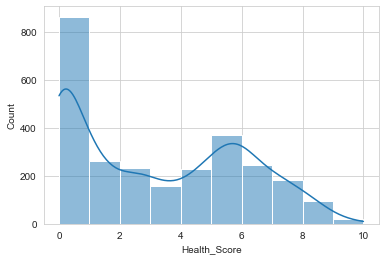

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure()
sns.set_style('whitegrid')
sns.histplot(df['Health_Score'] ,bins=10,kde=True)
plt.show()

Output

In [ ]:
df.to_csv('Notebooks Data Process/4. Health_Score.csv',index=0)